# Applying a Entailemnt Internalization

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import joypy

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# load data

In [2]:
result_path = "results/snli_lr_Tfidf_ent_int_25_25.csv"
ent_result_path = "results/snli_lr_Tfidf_ent_int_ent_25_25.csv"
neutral_result_path = "results/snli_lr_Tfidf_ent_int_neutral_25_25.csv"
contra_result_path = "results/snli_lr_Tfidf_ent_int_contra_25_25.csv"
result = pd.read_csv(result_path).set_index("pcts")

In [3]:
result_mean = result.reset_index().groupby("pcts").mean()
# ent_result_mean = ent_result.reset_index().groupby("pcts").mean()
# contra_result_mean = contra_result.reset_index().groupby("pcts").mean()
# neutral_result_mean = neutral_result.reset_index().groupby("pcts").mean()

## Plot Functions

In [4]:
def plot_error_bar(x, y, yerr, color1, color2, label):
    plt.plot(x, y, color=color1, linewidth=1)
    plt.errorbar(x=x, y=y, yerr=yerr,
                 color=color1, fmt='o',
                 ecolor=color2, elinewidth=1, label=label)

### Variables

In [5]:
alpha = 0.05
title = r'SNLI - logistic regression - entailment internalization (simulation under $H_0$)'

## Accuracy

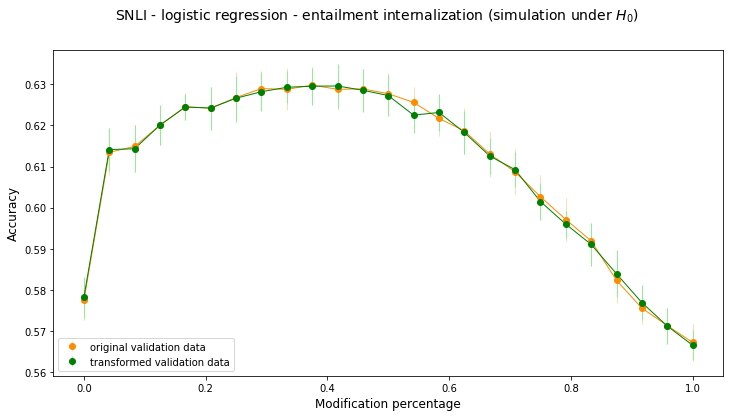

In [6]:
acc = result.groupby("pcts").mean()[["acc"]].values.flatten()
e_acc = result.groupby("pcts").std()[["acc"]].values.flatten()
x = result.groupby("pcts").mean().index 

acc_t = result.groupby("pcts").mean()[["acct"]].values.flatten()
e_acc_t = result.groupby("pcts").std()[["acct"]].values.flatten()


fig, ax = plt.subplots(1, 1, figsize=(12,6))

plot_error_bar(x=x,
               y=acc,
               yerr=e_acc,
               color1="darkorange",
               color2='navajowhite',
               label="original validation data")
plot_error_bar(x=x,
               y=acc_t,
               yerr=e_acc_t,
               color1="green",
               color2='lightgreen',
               label="transformed validation data")
fig.suptitle(title, fontsize=14);
ax.set_xlabel("Modification percentage", fontsize=12);
ax.set_ylabel("Accuracy", fontsize=12);
plt.legend(loc="lower left");

## Test statistic

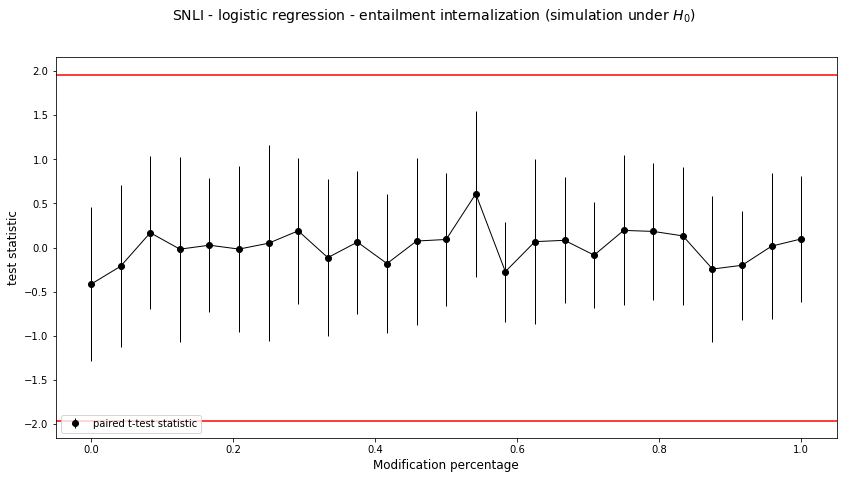

In [7]:
z_alpha_2 =  scipy.stats.norm.ppf(1  - (alpha/2))
t1_mean = result.groupby("pcts").mean()[["t1"]].values.flatten()
e_t1 = result.groupby("pcts").std()[["t1"]].values.flatten()
x = result.groupby("pcts").mean().index 

fig, ax = plt.subplots(1, 1, figsize=(14,7))

plot_error_bar(x=x,
               y=t1_mean,
               yerr=e_t1,
               color1="k",
               color2='k',
               label="paired t-test statistic")

fig.suptitle(title, fontsize=14);
plt.axhline(y=z_alpha_2, color='r', linestyle='-')
plt.axhline(y=-z_alpha_2, color='r', linestyle='-')
ax.set_xlabel("Modification percentage", fontsize=12);
ax.set_ylabel("test statistic", fontsize=12);
plt.legend(loc="lower left");

## P-values

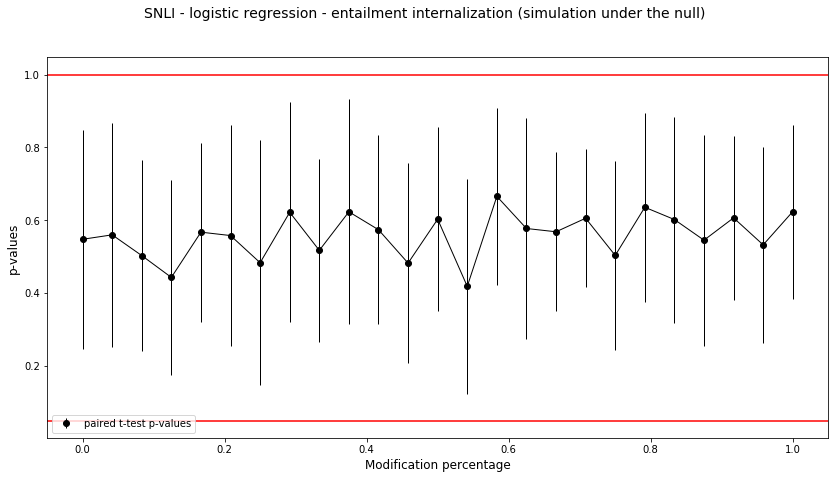

In [8]:
title = "SNLI - logistic regression - entailment internalization (simulation under the null)"

p_normal = lambda x: 2*scipy.stats.norm.cdf(- np.abs(x))
ps = result.t1.map(p_normal)
ps.name = "p_value"
ps = ps.reset_index()

p_mean = ps.groupby("pcts").mean()[["p_value"]].values.flatten()
e_p = ps.groupby("pcts").std()[["p_value"]].values.flatten()
x = ps.groupby("pcts").mean().index 

fig, ax = plt.subplots(1, 1, figsize=(14,7))

plot_error_bar(x=x,
               y=p_mean,
               yerr=e_p,
               color1="k",
               color2='k',
               label="paired t-test p-values")

fig.suptitle(title, fontsize=14);
plt.axhline(y=1, color='r', linestyle='-')
plt.axhline(y=alpha, color='r', linestyle='-')
ax.set_xlabel("Modification percentage", fontsize=12);
ax.set_ylabel("p-values", fontsize=12);
plt.legend(loc="lower left");

## Interval analysis

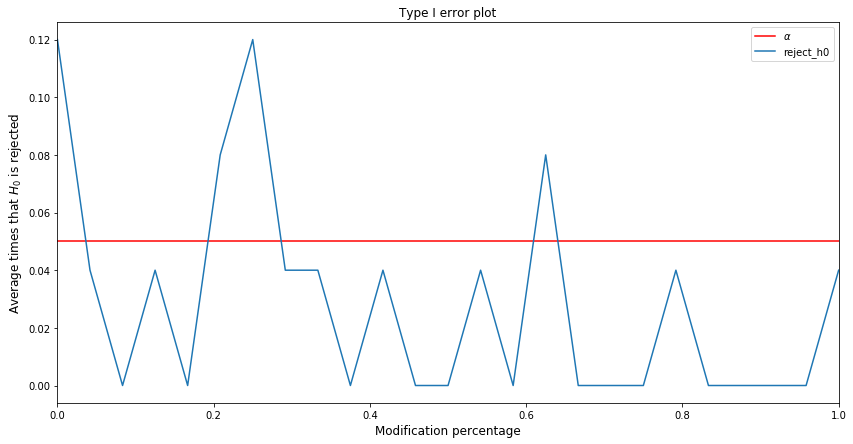

In [9]:
result_ = result.reset_index()
result_.loc[:, "p_values"] = result_.t1.map(p_normal)
result_.loc[:, "reject_h0"] = (result_.p_values < alpha).astype(int)

fig, ax = plt.subplots(1,1,figsize=(14,7))
plt.axhline(y=alpha, color='r', linestyle='-', label=r"$\alpha$")
result_.groupby("pcts").mean().reject_h0.plot(ax=ax, title="Type I error plot");
ax.set_xlabel("Modification percentage", fontsize=12);
ax.set_ylabel(r"Average times that $H_0$ is rejected", fontsize=12);
plt.legend(loc="best");

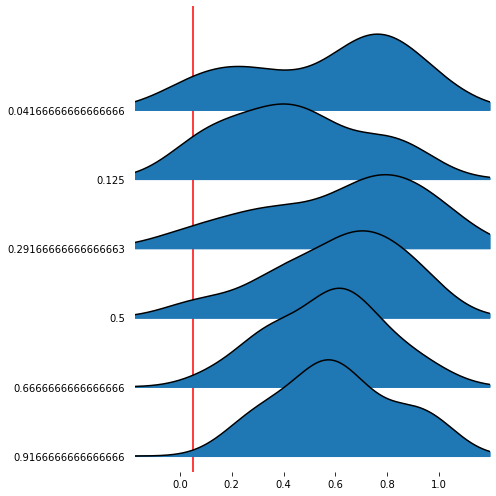

In [10]:
good = result_.groupby("pcts").mean().reject_h0[result_.groupby("pcts").mean().reject_h0 <= alpha]
i_s = np.random.choice(good.index.unique(), 6)
result_good = result_[result_['pcts'].isin(i_s)]
fig, ax = plt.subplots(1,1,figsize=(7,7))
plt.axvline(x=alpha, color='r', linestyle='-');
joypy.joyplot(result_good, by="pcts", column="p_values",ax=ax);
plt.axvline(x=alpha, color='r', linestyle='-');

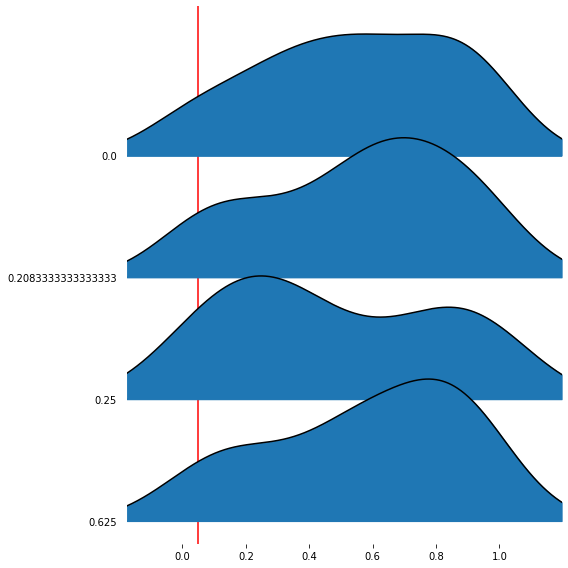

In [11]:
bad = result_.groupby("pcts").mean().reject_h0[result_.groupby("pcts").mean().reject_h0 > alpha]
result_bad = result_[result_['pcts'].isin(bad.index.unique())]
fig, ax = plt.subplots(1,1,figsize=(8,8))
joypy.joyplot(result_bad, by="pcts", column="p_values",ax=ax);
plt.axvline(x=alpha, color='r', linestyle='-');